In [2]:
from google.colab import files
uploaded = files.upload()

Saving monthly_sales.csv to monthly_sales.csv


In [3]:
import pandas as pd
monthly_sales = pd.read_csv('monthly_sales.csv', index_col=0)
monthly_sales.index = pd.to_datetime(monthly_sales.index)
monthly_sales.head()

,monthly_sales
order_date,
2014-01-31,14236.895
2014-02-28,4519.892
2014-03-31,55691.009
2014-04-30,28295.345
2014-05-31,23648.287


In [4]:
# 📌 STEP 1: Normalize the data
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(monthly_sales[['monthly_sales']])

In [5]:
# 📌 STEP 2: Create sequences for LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_sequences(sales_scaled, window_size)

print(f"Shape of X: {X.shape}, y: {y.shape}")


Shape of X: (45, 3, 1), y: (45, 1)


In [6]:
# 📌 STEP 3: Build LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 📌 STEP 4: Train model
model.fit(X, y, epochs=100, verbose=1)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2030
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1926
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1847
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1748
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1648
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1558
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1452
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1371
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1253
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1139
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1069
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1028
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0974
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0901
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0878
Epoch 16/100
2/2 ━━

In [8]:
# 📌 STEP 5: Predict next value (1 month ahead)
last_sequence = sales_scaled[-window_size:]
next_month_pred = model.predict(last_sequence.reshape(1, window_size, 1))
next_month_sales = scaler.inverse_transform(next_month_pred)
print(f"📈 Predicted sales for next month: ₹{next_month_sales[0][0]:,.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
📈 Predicted sales for next month: ₹77,185.63


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


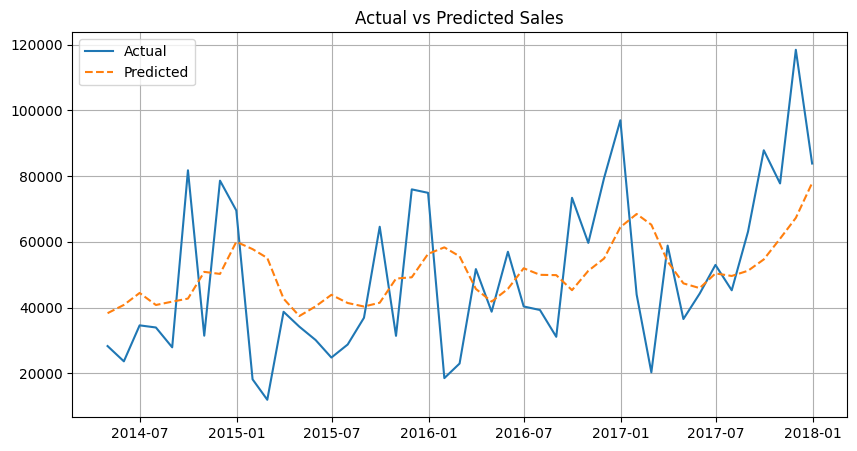

In [9]:
# Predict full series for comparison
import matplotlib.pyplot as plt

y_pred = model.predict(X)
y_pred_inv = scaler.inverse_transform(y_pred)
y_true_inv = scaler.inverse_transform(y)

plt.figure(figsize=(10,5))
plt.plot(monthly_sales.index[window_size:], y_true_inv, label='Actual')
plt.plot(monthly_sales.index[window_size:], y_pred_inv, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.grid()
plt.show()

In [11]:
from tensorflow.keras.losses import MeanSquaredError

model.compile(optimizer='adam', loss=MeanSquaredError())
model.save("lstm_model.h5")

In [12]:
# model.save("lstm_model.h5")

from google.colab import files
files.download("lstm_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>